In [58]:
import torch
import torch.nn as nn

import random
import converter
import copy

import numpy as np
from IPython.display import SVG, display
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec
from cairosvg import svg2png
import svgwrite
from PIL import Image
import io
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import glob
from grokfast import gradfilter_ma, gradfilter_ema

In [59]:
def show(vec):
    svg = c.to_svg(vec, scale=150)
    display(svg_to_pil(svg))

def svg_to_pil(svg):
    dwg = svgwrite.Drawing(
        '',
        profile='tiny',
        fill_rule="evenodd", 
        size=(f"{svg['width']}px", f"{svg['height']}px")
    )

    dwg.add(
        dwg.path( d=svg['d'].d(),
        fill="#000")
    )
    svg_string = dwg.tostring()
    png_data = svg2png(bytestring=svg_string.encode('utf-8'))
    pil_image = Image.open(io.BytesIO(png_data)) 
    return pil_image

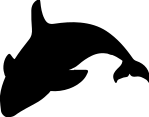

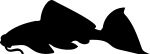

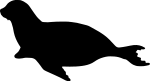

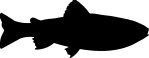

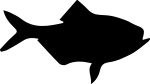

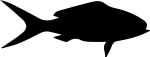

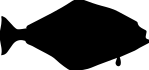

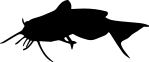

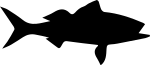

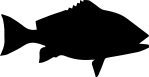

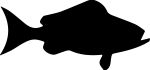

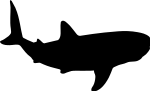

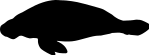

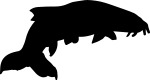

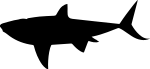

In [60]:
seq_len = 200
d_model = 11

c = converter.Converter(seq_len)

svg_pathhs = glob.glob('evaluate/fish/**/*.svg', recursive=True)

arr = []
for svg_pathh in svg_pathhs:
    svg = c.open(svg_pathh)
    dots, vector_distorted = c.to_vector(svg)
    vector02 = torch.tensor(vector_distorted)

    show(vector_distorted)
    arr.append(vector02)

arr = np.array(arr)

X_train, X_test = train_test_split(arr, test_size=0.2, random_state=42)

out_vec = torch.tensor(X_train)
out_vec_test = torch.tensor(X_test)
    
class Conv1D_VAE(nn.Module):
    def __init__(self, d_model=11, seq_len=30, latent_dim=4, dropout_rate=0.0001):
        super(Conv1D_VAE, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        
        conv_size = 16
        self.conv_size = conv_size
        
        self.encoder = nn.Sequential(
              nn.Conv1d(d_model, conv_size, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm1d(conv_size),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.LeakyReLU(0.2),
              nn.Dropout(self.dropout_rate),
            
              nn.Conv1d(conv_size, conv_size//2, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm1d(conv_size//2),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.LeakyReLU(0.2),
              nn.Dropout(self.dropout_rate),
            
              nn.Conv1d(conv_size//2, conv_size//4, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm1d(conv_size//4),
              nn.MaxPool1d(kernel_size=2, stride=2), 
              nn.LeakyReLU(0.2),
              nn.Dropout(self.dropout_rate),
            )

        self.latent_encoder = nn.Linear((conv_size//4) * (seq_len//8), latent_dim)
        self.latent_act = nn.Tanh()
        self.latent_dropout = nn.Dropout(self.dropout_rate) 
        
        self.latent_decoder = nn.Linear(latent_dim, (conv_size//4) * (seq_len//8))
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(conv_size//4, conv_size//2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(conv_size//2),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate),
            
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(conv_size//2, conv_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(conv_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate),
            
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(conv_size, d_model, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(d_model),
            nn.LeakyReLU(0.2),
            nn.Dropout(self.dropout_rate),
        )
        

        self.coords = nn.Linear(d_model, 6)
        self.type_ = nn.Linear(d_model, 4)
        self.type_act = nn.Softmax(dim=2)
        
        self.pad = nn.Linear(d_model, 1)
        self.pad_act = nn.Sigmoid()
        
    def encode(self, x):
        x = x.permute(0, 2, 1) # Reshape for 1D conv (batch, channels, sequence)
        
        x = self.encoder(x)
        
        x = x.reshape(x.size(0), -1) # Flatten for linear layers
        
        x = self.latent_encoder(x)
        x = self.latent_act(x)
        x = self.latent_dropout(x) 
        
        return x


    def decode(self, z):
        z = self.latent_decoder(z)
        z = z.reshape(z.size(0), self.conv_size//4, self.seq_len//8) # Reshape back for conv transpose
        
        z = self.decoder(z)
        
        z = z.permute(0, 2, 1) # Restore original shape
        
        coords = self.coords(z)
        type_ = self.type_act(self.type_(z))
        pad = self.pad_act(self.pad(z))
        
        z = torch.cat((coords, type_, pad), dim=2)
        
        return z 

    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out
    
model = Conv1D_VAE(seq_len=seq_len)

opt = torch.optim.Adam(model.parameters(), lr=0.003)

loss_fn = nn.MSELoss()

In [56]:
out_vec.size(), out_vec_test.size()
metrics = {'train_loss': [], 'test_loss': []}

Epoch 13001, test_loss: 0.02600305899977684


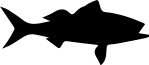

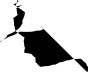

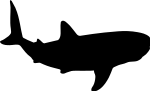

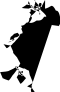

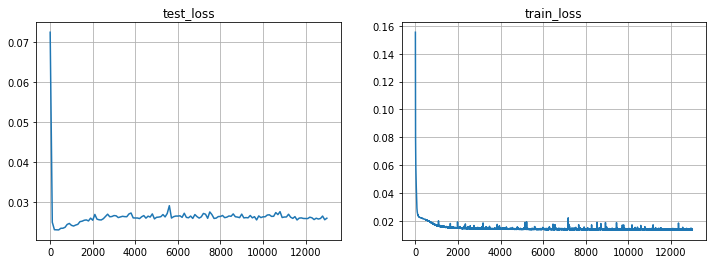

KeyboardInterrupt: 

In [57]:


grads = None
alpha = 0.8
lamb = 0.1
window_size = 2


for step in range(100000):
    model.train()
    
    out  = model(out_vec)

    loss = loss_fn(out, out_vec)
        
    opt.zero_grad()
    loss.backward()
    
#     grads = gradfilter_ema(model, grads=grads, alpha=alpha, lamb=lamb)
    grads = gradfilter_ma(model, grads=grads, window_size=window_size, lamb=lamb)
    
    opt.step()

    metrics['train_loss'].append((step, loss.item()))
    if step%100 == 0:
        
        model.eval()
        out_test  = model(out_vec_test)
        loss = loss_fn(out_test, out_vec_test)
        metrics['test_loss'].append((step, loss.item()))
        
        try:
            clear_output()
            print(f"Epoch {step+1}, test_loss: {loss.item()}")

            show(out_vec[2].tolist())
            show(out[2].tolist())
            show(out_vec_test[1].tolist())
            show(out_test[1].tolist())
            
        except Exception as e:
            print(e)
            
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

In [ ]:
def show_grid(X, model, rows=5, cols=5, figsize=(12, 12)):

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(rows, cols)

    i = 0
    for x in X:
        for y in X:
            input_vec = torch.tensor([x, 1]).reshape(-1, 2)
            out = model.decode(input_vec)
            
            try:
                svg = c.to_svg(out[0].tolist())
            
                img = svg_to_pil(svg)
#                 display(img)
    
                ax = fig.add_subplot(gs[i])
                ax.imshow(img) 
                ax.axis('off')
                
                               
            except Exception as e:
                print(e)
            i += 1
                
            
            

    plt.tight_layout()
    plt.show()

tensor([[-0.0100, -0.9325, -0.9282,  0.9747],
        [ 0.9949, -0.1494,  0.1800, -0.9997],
        [ 0.9942,  0.3255,  0.5564,  0.9991],
        [ 1.0000,  1.0000, -0.9899, -0.2392],
        [-0.9979, -0.6840,  0.2457,  0.8447],
        [-0.7196,  0.1388,  0.0543, -1.0000],
        [-0.6108,  0.9951,  0.0977,  0.4002],
        [ 0.8719, -0.9996,  0.9278,  0.4345],
        [ 0.6154,  0.9548,  0.9957, -0.5266]], grad_fn=<TanhBackward0>)


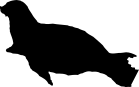

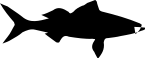

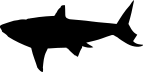

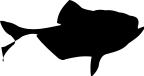

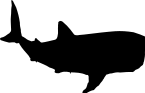

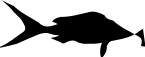

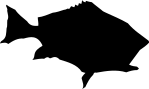

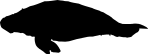

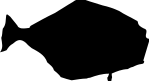

In [56]:
model.eval()
x = out_vec
z = model.encode(x)
print(z)
out = model.decode(z)
for svg in out:
    show(svg.tolist())

In [57]:
from_id = 2
to_id = 3
d = z[to_id] - z[from_id]
d

tensor([ 0.0058,  0.6745, -1.5463, -1.2382], grad_fn=<SubBackward0>)

In [58]:
z[from_id], z[to_id]

(tensor([0.9942, 0.3255, 0.5564, 0.9991], grad_fn=<SelectBackward0>),
 tensor([ 1.0000,  1.0000, -0.9899, -0.2392], grad_fn=<SelectBackward0>))

In [59]:
n = 10
# X = torch.arange(n+1)/(n)
X = torch.arange(n+1)/n
X = X.reshape(n+1, -1)
X = X.repeat(1, 4)

z = z[from_id] + X*d
z

tensor([[ 0.9942,  0.3255,  0.5564,  0.9991],
        [ 0.9947,  0.3930,  0.4018,  0.8753],
        [ 0.9953,  0.4604,  0.2471,  0.7514],
        [ 0.9959,  0.5279,  0.0925,  0.6276],
        [ 0.9965,  0.5953, -0.0621,  0.5038],
        [ 0.9971,  0.6628, -0.2167,  0.3800],
        [ 0.9977,  0.7302, -0.3714,  0.2561],
        [ 0.9982,  0.7977, -0.5260,  0.1323],
        [ 0.9988,  0.8651, -0.6806,  0.0085],
        [ 0.9994,  0.9326, -0.8352, -0.1153],
        [ 1.0000,  1.0000, -0.9899, -0.2392]], grad_fn=<AddBackward0>)

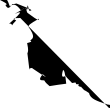

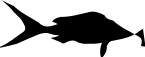

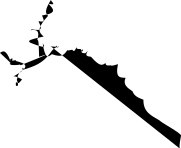

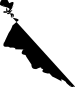

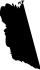

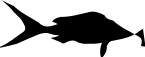

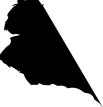

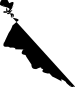

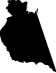

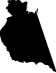

In [63]:
model.eval()

z = model.encode(out_vec_test)
# z += torch.randn_like(z)
out = model.decode(z)
for svg in out:
    show(svg.tolist())